# K - Nearest Neighbors

In [11]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

sys.path.append('../src') # permite importar modulos locales
pd.options.display.max_columns = None # permite mostrar todas las columnas de los DataFrames

In [3]:
from ds_preprocessing import DataSetPreprocessor
from arff_helper import DataSet
from metrics import accuracy_score
from kfold import KFold
from classifier import KNNClassifier

## Preprocesamiento del dataset de entrenamiento

Se preprocesa el dataset de entrenamiento para transformarlo en otro que permita calcular distancias euclidianas entre las instancias

In [5]:
training_ds = DataSet()
training_ds.load_from_arff('../datasets/Autism-Adult-Training-Subset.arff')
preprocessor = DataSetPreprocessor(training_ds, 'Class/ASD')
preprocessed_training_df = preprocessor.transform_to_rn()

## Testeo general

### Resultados de predicciones 

El objetivo aquí es observar los valores devueltos para el atributo objetivo (```YES``` o ```NO```). Se toman N instancias al azar del conjunto de entrenamiento y se imprimen los valores. 

In [4]:
N = 5
test_df = preprocessed_training_df.sample(N)
training_df = preprocessed_training_df.loc[~preprocessed_training_df.index.isin(test_df.index), :]\
    .reset_index()\
    .drop(columns=['index'], axis=1)
test_df = test_df\
    .reset_index()\
    .drop(columns=['index'], axis=1)

classifier = KNNClassifier(1, target_attribute='Class/ASD')
classifier.fit(training_df)

print()
for i in range(N):
    predicted_value = classifier.predict(test_df.loc[i])
    real_value = test_df.loc[i]['Class/ASD']
    print('Real value : {}, Predicted: {}'.format(real_value, predicted_value))
print()


Real value : NO, Predicted: NO
Real value : NO, Predicted: NO
Real value : NO, Predicted: NO
Real value : NO, Predicted: NO
Real value : YES, Predicted: YES



### Instancias vecinas

El objetivo aquí es observar las instancias vecinas (determinadas por K) de las instancias que se quieren predecir para ver las similitudes y/o diferencias. La primer instancia en la tabla corresponde a la que se quiere predecir y las siguientes son sus vecinas. Se reordenan las columnas de dicha tabla de forma que las dos últimas columnas sean: 

- ```Class/ASD``` : atributo objetivo 
- ```distance``` : distancia entre la instancia correspondiente a la fila y la instancia que se quiere predecir (primer fila)

In [7]:
instance_index = 536 # indice en el DataFrame original
instance = preprocessed_training_df.iloc[[instance_index]]
training_df = preprocessed_training_df.loc[~preprocessed_training_df.index.isin([instance_index]), :]\
    .reset_index()\
    .drop(columns=['index'], axis=1)
instance = instance.reset_index()\
    .drop(columns=['index'], axis=1)

classifier = KNNClassifier(3, target_attribute='Class/ASD')
classifier.fit(training_df)
(predicted_value, neighbours) = classifier.predict(instance.loc[0], return_neighbours=True)
print('\nPredicted value = {}'.format(predicted_value))
df = pd.concat([instance, neighbours])
cols = list(df.columns.values)
cols.pop(cols.index('Class/ASD'))
cols.pop(cols.index('distance')) 
df[cols+['Class/ASD','distance']]


Predicted value = YES


,A10_Score,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,age,age_desc_18 and more,austim_no,austim_yes,contry_of_res_Afghanistan,contry_of_res_AmericanSamoa,contry_of_res_Angola,contry_of_res_Argentina,contry_of_res_Armenia,contry_of_res_Aruba,contry_of_res_Australia,contry_of_res_Austria,contry_of_res_Azerbaijan,contry_of_res_Bahamas,contry_of_res_Bangladesh,contry_of_res_Belgium,contry_of_res_Bolivia,contry_of_res_Brazil,contry_of_res_Burundi,contry_of_res_Canada,contry_of_res_Chile,contry_of_res_China,contry_of_res_Costa Rica,contry_of_res_Cyprus,contry_of_res_Czech Republic,contry_of_res_Ecuador,contry_of_res_Egypt,contry_of_res_Ethiopia,contry_of_res_Finland,contry_of_res_France,contry_of_res_Germany,contry_of_res_Hong Kong,contry_of_res_Iceland,contry_of_res_India,contry_of_res_Indonesia,contry_of_res_Iran,contry_of_res_Iraq,contry_of_res_Ireland,contry_of_res_Italy,contry_of_res_Japan,contry_of_res_Jordan,contry_of_res_Kazakhstan,contry_of_res_Lebanon,contry_of_res_Malaysia,contry_of_res_Mexico,contry_of_res_Nepal,contry_of_res_Netherlands,contry_of_res_New Zealand,contry_of_res_Nicaragua,contry_of_res_Niger,contry_of_res_Oman,contry_of_res_Pakistan,contry_of_res_Philippines,contry_of_res_Portugal,contry_of_res_Romania,contry_of_res_Russia,contry_of_res_Saudi Arabia,contry_of_res_Serbia,contry_of_res_Sierra Leone,contry_of_res_South Africa,contry_of_res_Spain,contry_of_res_Sri Lanka,contry_of_res_Sweden,contry_of_res_Tonga,contry_of_res_Turkey,contry_of_res_Ukraine,contry_of_res_United Arab Emirates,contry_of_res_United Kingdom,contry_of_res_United States,contry_of_res_Uruguay,contry_of_res_Viet Nam,ethnicity_Asian,ethnicity_Black,ethnicity_Hispanic,ethnicity_Latino,ethnicity_Middle Eastern,ethnicity_Others,ethnicity_Pasifika,ethnicity_South Asian,ethnicity_Turkish,ethnicity_White-European,ethnicity_others,gender_f,gender_m,jundice_no,jundice_yes,relation_Health care professional,relation_Others,relation_Parent,relation_Relative,relation_Self,used_app_before_no,used_app_before_yes,Class/ASD,distance
0,1,1,1,0,1,0,0,0,1,0,-0.344603,1,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NO,NaN
441,1,1,0,1,1,1,1,1,1,0,-0.513547,1,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,YES,2.242441
165,1,1,1,1,1,1,0,0,1,1,0.331175,1,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,YES,2.335953
247,1,1,0,0,0,0,0,0,1,0,-0.513547,1,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NO,2.455309


## Evaluación del algoritmo

### Evaluación de accuracy con K-Fold


...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...
...


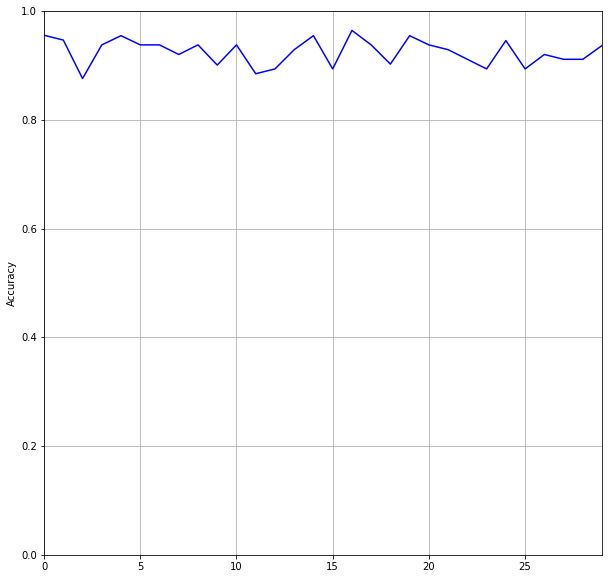

In [25]:
n = 6
k_for_k_fold = 5
k_for_knn = 3
target_attribute='Class/ASD'
accuracies = []
classifier = KNNClassifier(k_for_knn, target_attribute)

for i in range(n):
    
    kf = KFold(n_splits=5, do_shuffle=True)
    indexes = kf.split(preprocessed_training_df)
    
    for test_indexes, training_indexes in indexes:
        
        df_test = preprocessed_training_df.iloc[test_indexes]
        df_train = preprocessed_training_df.iloc[training_indexes] \
            .reset_index()\
            .drop(columns=['index'], axis=1) # prevent warning ../src/k_nearest_neighbor.py:31: SettingWithCopyWarning
        
        classifier.fit(df_train)
        
        y_predicted = df_test.apply(lambda row: classifier.predict(row), axis=1)
        y_true = df_test[target_attribute]
        
        print('...')
        accuracies.append(accuracy_score(y_predicted, y_true))
        
plt.figure(figsize=(10,10))
plt.ylabel('Accuracy')
plt.axis([0, (n*k_for_k_fold)-1, 0, 1])
plt.grid(True)

plt.plot(accuracies, color='b')
plt.show()